In [1]:
import torch 
import torch.nn as nn
import numpy as np
import torchvision.datasets.mnist as mnist
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader
from perceptron import Perceptron, Ansamble
import torchvision.transforms as trnsfrms
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

In [2]:
def draw_sample(X, Y, num_images_to_show=5):
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(30, 12))
    pil = ToPILImage()
    for i in range(num_images_to_show):
        image, label = X[i], Y[i]
        image = pil(image.reshape(28, 28))
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()

In [3]:
transform = trnsfrms.Compose([
    trnsfrms.ToTensor()
])

full_train_set =  mnist.MNIST('./data', download=True, train=True, transform=transform)
full_test_set = mnist.MNIST('./data', download=True, train=False, transform=transform)
full_train_x, full_train_y = full_train_set.data.reshape(-1, 28*28), full_train_set.targets
full_test_x, full_test_y = full_test_set.data.reshape(-1, 28*28), full_test_set.targets

digit_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train_ind = [i for i, label in enumerate(full_train_y) if label in digit_labels]
test_ind = [i for i, label in enumerate(full_test_y) if label in digit_labels]

dig_train_x, dig_train_y = full_train_x[train_ind], full_train_y[train_ind]
dig_test_x, dig_test_y = full_test_x[test_ind], full_test_y[test_ind]


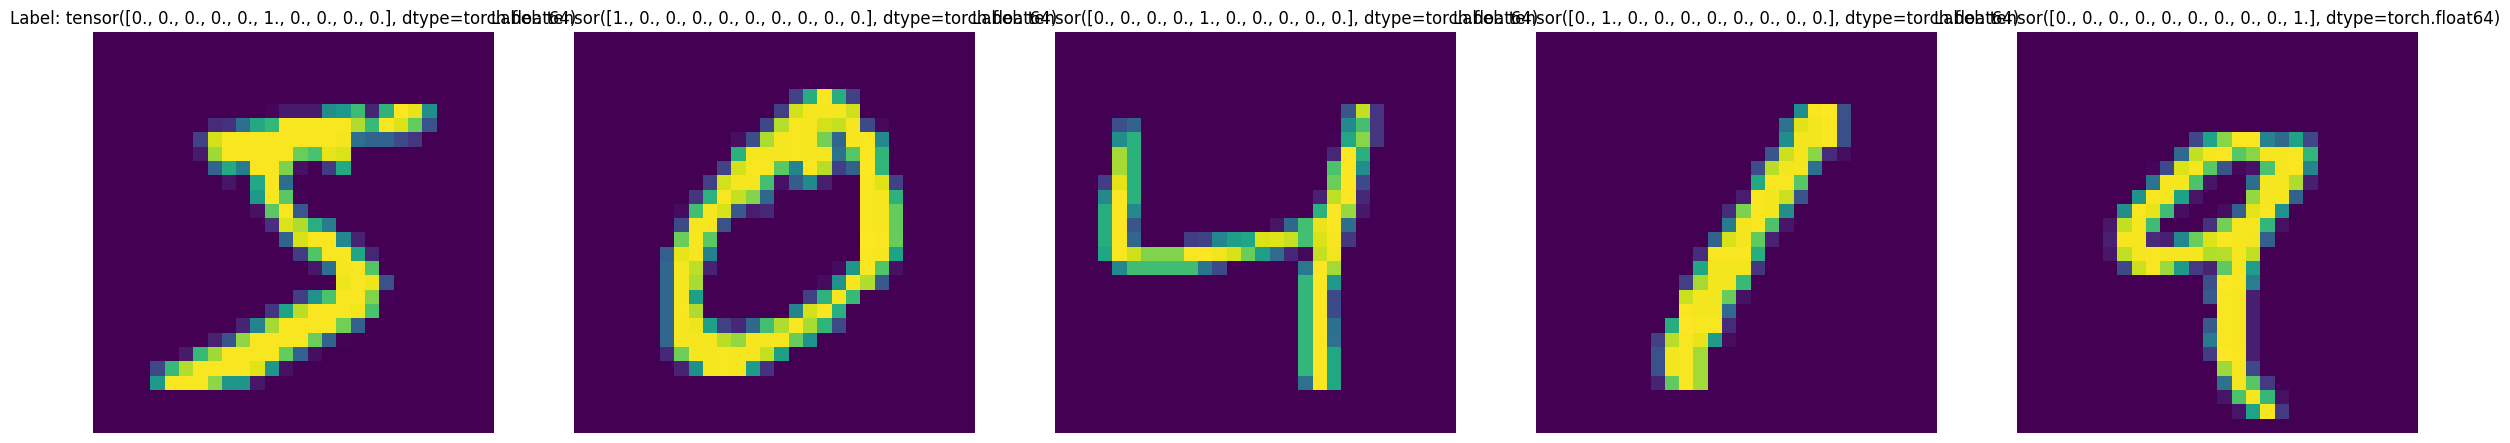

In [4]:
#dig_train_y_encoded = one_hot(dig_train_y, num_classes=10)
dig_train_y_encoded = torch.zeros(dig_train_y.shape[0], 10, dtype=torch.float64)
dig_train_y_encoded[torch.arange(dig_train_y.shape[0]), dig_train_y] = 1

dig_test_y_encoded = torch.zeros(dig_test_y.shape[0], 10, dtype=torch.float64)
dig_test_y_encoded[torch.arange(dig_test_y.shape[0]), dig_test_y] = 1
draw_sample(dig_train_x, dig_train_y_encoded)

In [5]:
def draw_heatmap(y_pred, y_true):
    with torch.no_grad():
        conf_matr = confusion_matrix(y_true, y_pred)
        classes = y_true.unique().tolist()
        dataframe = pd.DataFrame(conf_matr, index=classes, columns=classes)
        sns.heatmap(dataframe, annot=True, cbar=False, cmap="YlGnBu",fmt="d")

0.6720131972744892
0.7415


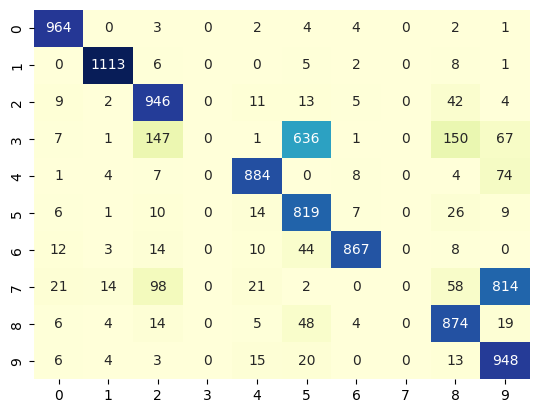

In [13]:
perceptron = Perceptron(input_size=28*28, output_size=10, epoch=50, batch_size=100, lr=0.0005)
perceptron.fit(dig_train_x, dig_train_y_encoded)
dig_test_pred = perceptron.predict(dig_test_x)
print(f1_score(dig_test_y, dig_test_pred, average='macro'))
print(accuracy_score(dig_test_y, dig_test_pred))
draw_heatmap(dig_test_pred, dig_test_y)

0.906964593282862
0.9088


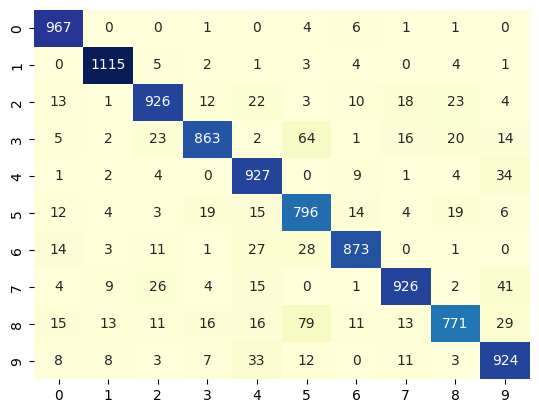

In [14]:
ansamble = Ansamble(model=Perceptron, input_size=28*28, output_size=10, models_num=10, train_size=0.8, epoch=10, batch_size=100, lr=0.0005)
ansamble.fit(dig_train_x, dig_train_y_encoded)
dig_test_pred = ansamble.predict(dig_test_x)
print(f1_score(dig_test_y, dig_test_pred, average='macro'))
print(accuracy_score(dig_test_y, dig_test_pred))
draw_heatmap(dig_test_pred, dig_test_y)

In [12]:
class MLP(nn.Module):
    def __init__(self, hidden_layers_num=3, neyrons_num=5, activation_func=nn.ReLU):
        super().__init__()
        hidden_layers = []
        for i in range(hidden_layers_num-1):
            hidden_layers.append(nn.Linear(neyrons_num, neyrons_num, dtype=torch.float64))
            hidden_layers.append(activation_func())
        self.model = nn.Sequential(
            nn.Linear(1, neyrons_num, dtype=torch.float64), 
            activation_func(),        
            *hidden_layers,
            nn.Linear(neyrons_num, 1, dtype=torch.float64),
        )

    def forward(self, x):
        return self.model(x)
    
    def fit(self, X: torch.Tensor, Y: torch.Tensor, epochs=3000, batch_size=20, lr=0.1, tracking_loss=False):
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)

        for epoch in range(epochs):
            self.model.train() 
            indices = torch.randperm(X.shape[0])
            x, y = X[indices], Y[indices]
            for i in range(0, X.shape[0], batch_size):
                x_batch, y_batch = x[i:i+batch_size], y[i:i+batch_size]

                outputs = self.model(x_batch)
                loss = self.criterion(outputs, y_batch) 
                
                self.optimizer.zero_grad()
                loss.backward() 
                self.optimizer.step() 

            if (tracking_loss and (epoch+1) % 10 == 0):
                print(f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')
                
    def predict(self, X):
        self.model.eval() 
        return self.forward(X)
        

In [10]:
x_polinom = np.linspace(-1, 1, 1000)
a, b, c, d = np.random.uniform(low=-3, high=3, size=4)
y_polinom = a * x_polinom**3 + b * x_polinom**2 + c * x_polinom + d

In [91]:
N = 20
x = np.random.uniform(low=-1, high=1, size=N)
y = a * x**3 + b * x**2 + c * x + d + np.random.normal(0, 0.5, N)

In [97]:
def draw_polinom_regression(num_of_layers, neyrons_num, epochs, lr, batch_size, func=nn.ReLU):
    model = MLP(hidden_layers_num=num_of_layers, neyrons_num=neyrons_num, activation_func=func)
    model.fit(torch.tensor(x).reshape(-1, 1), torch.tensor(y).reshape(-1, 1), epochs=epochs, batch_size=batch_size, lr=lr)
    xx = np.linspace(-1, 1, 10000)
    
    plt.plot(xx, model.predict(torch.tensor(xx).reshape(-1, 1)).detach().numpy(), color="red")
    plt.scatter(x, y, color="blue")
    plt.plot(x_polinom, y_polinom, color="green")
    
    plt.ylim(y.min() - 2, y.max() + 2)
    plt.title(f'Layers: {num_of_layers}, Neurons: {neyrons_num}, lr: {lr}')
    plt.show()

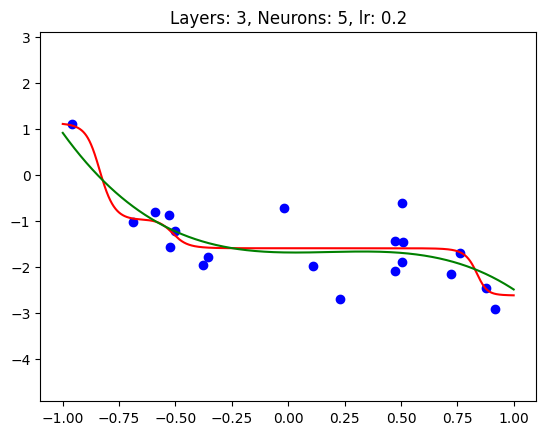

In [98]:
draw_polinom_regression(num_of_layers=3, neyrons_num=5, epochs=1000, lr=0.2,batch_size=N//5, func=nn.Tanh)

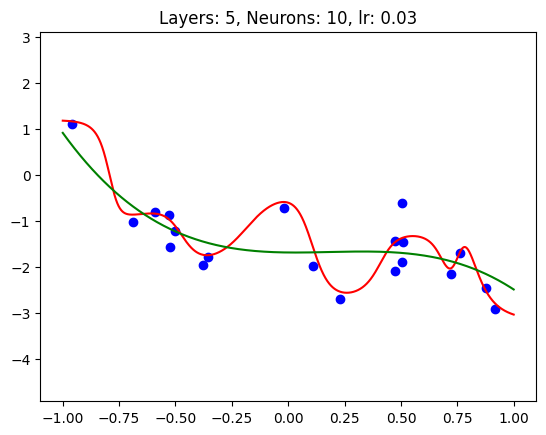

In [105]:
draw_polinom_regression(num_of_layers=5, neyrons_num=10, epochs=10000, lr=0.03, batch_size=N//5,func=nn.Tanh)

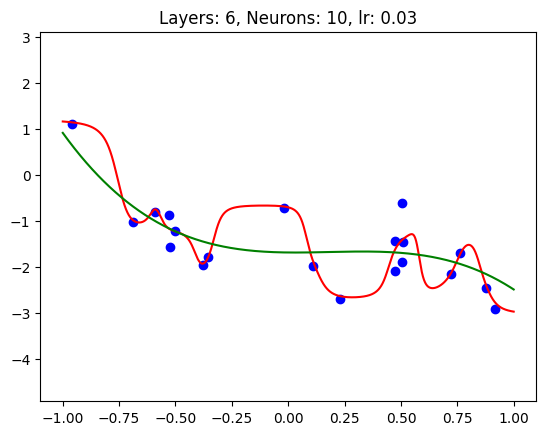

In [108]:
draw_polinom_regression(num_of_layers=6, neyrons_num=10, epochs=10000, lr=0.03, batch_size=N//10,func=nn.Tanh)

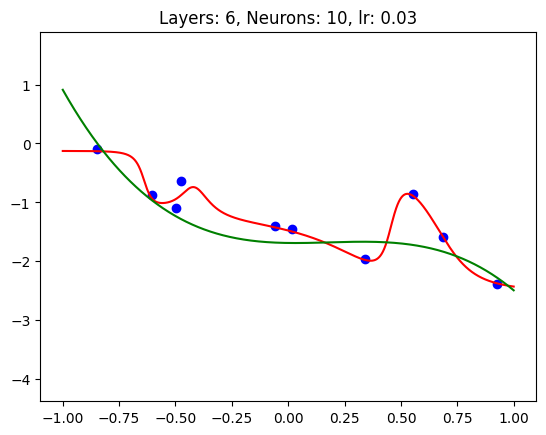

In [109]:
N = 10
x = np.random.uniform(low=-1, high=1, size=N)
y = a * x**3 + b * x**2 + c * x + d + np.random.normal(0, 0.5, N)
draw_polinom_regression(num_of_layers=6, neyrons_num=10, epochs=10000, lr=0.03, batch_size=N//10,func=nn.Tanh)